# Instacart Online Grocery Shopping

Introduction:

Instacart is an American company that operates as a same-day grocery delivery service. Customers select groceries through a web application from various retailers and delivered by a personal shopper. Recently in 2017, Instacart had released the Dataset which contains a sample of 3 million grocery store orders from more than 200,000 Instacart users.  

Each user, has 4 to 100 of their orders, with the sequence of products purchased in each order.It also provides the week and hour of day the order was placed, and a relative measure of time between orders.

Importing the necessary libraries:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display
from matplotlib import figure
import pylab as pl
import scipy.sparse as ssp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
%matplotlib inline

Reading all the files

In [4]:
aisle=pd.read_csv("./aisles.csv")
department=pd.read_csv("./departments.csv")
product=pd.read_csv("./products.csv")
order_product_prior=pd.read_csv("./order_products__prior.csv")
order_product_train=pd.read_csv("./order_products__train.csv")
orders=pd.read_csv("./orders.csv")

In [5]:
print(aisle.head(5))
print('Total aisle: {}'.format(aisle.shape[0]))

   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation
Total aisle: 134


In [6]:
print(department.head(5))
print('Total department: {}'.format(department.shape[0]))

   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol
Total department: 21


In [7]:
print(product.head(5))
print('Total product: {}'.format(product.shape[0]))

   product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13  
Total product: 49688


In [8]:
print(order_product_prior.head(5))
print('Total count: {}'.format(order_product_prior.shape[0]))

   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0
Total count: 32434489


In [9]:
print(orders.head(5))
print('Total count: {}'.format(orders.shape[0]))

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  
Total count: 3421083


Merging the datasets to get the records in a single dataframe based on the join for product_id, aisle_id
and department_id.

In [10]:
order_products_prior_df = pd.merge(order_product_prior, product, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisle, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, department, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [11]:
#Checking for null records.
Total_null=order_products_prior_df.isnull().sum()
print(Total_null)

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
product_name         0
aisle_id             0
department_id        0
aisle                0
department           0
dtype: int64


# Exploratory Data Analysis

Plot1: The below plot gives the departments from which maximum items are sold.

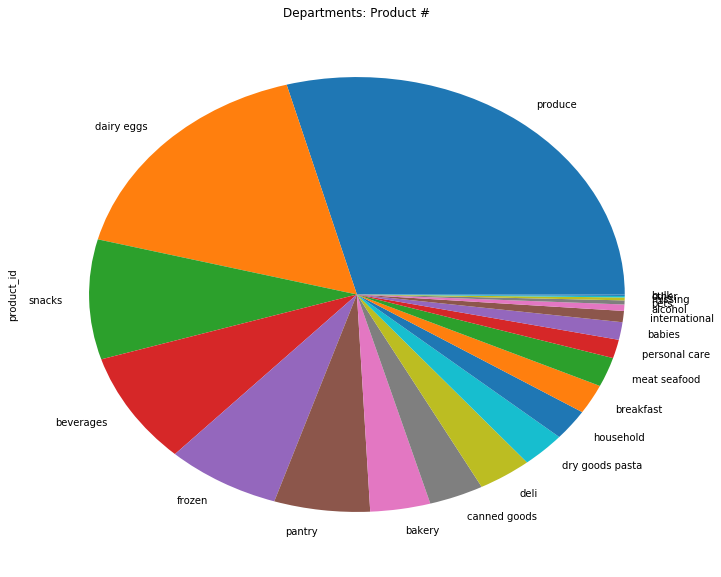

In [12]:
plt.figure(figsize=(12, 10))
order_products_prior_df.groupby(['department']).count()['product_id'].copy().sort_values(ascending=False).plot(kind='pie',title='Departments: Product #')

Inference:
We can see that the maximum amount of items are sold from the produce department followed by dairy eggs, 
snacks and beverages. From the departments where there are less items sold we can try and bring out schemes 
which would link these items to the departments with maximum sales so as to improve the number of items sold 
from the other departments.

Plot2: The bar graph below shows from which aisle maximum products are sold.

C:\Users\Owner\Anaconda3\lib\site-packages\pandas\plotting\_core.py:186: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


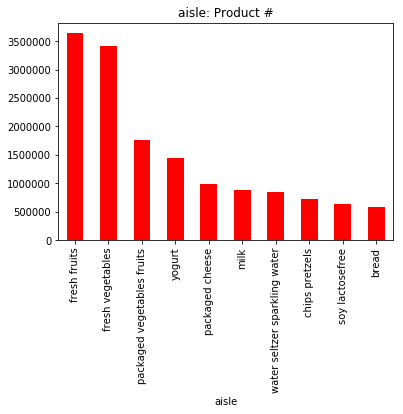

In [13]:
order_products_prior_df.groupby(['aisle']).count()['product_id'].copy().sort_values(ascending=False)[:10].plot(kind='bar',title='aisle: Product #',colors='red')

Infernece: 
We can see that fresh fruits and fresh vegetable isles sell the maximum products. 
Aisles which do not have much sales, we can try and advertise those aisles.

Plot3:We are doing this to check the number of occurences of a customer.

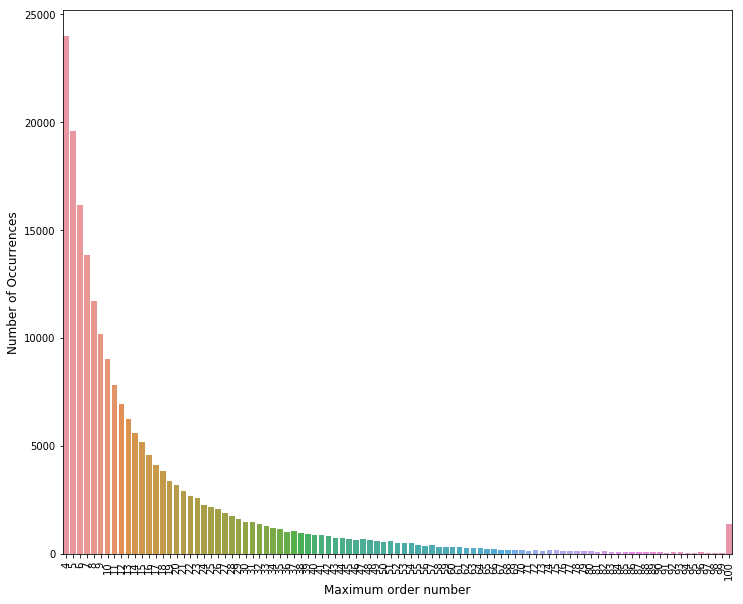

In [14]:
NumOfOrdersperUser = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
NumOfOrdersperUser = NumOfOrdersperUser.order_number.value_counts()
plt.figure(figsize=(12,10))
sns.barplot(NumOfOrdersperUser.index, NumOfOrdersperUser.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Infernece:
The dataset says that it has users who have ordered atleast 4 times and the maximum times is capped to 100.
From this insight we can say that people who have ordered more than 60 times are those
who are now the regular customers.
People who have ordered less than 10 times are the potential regular customers and 
we can identify them and give them interesting deals so as to attract them to visit us more in future.

Plot4: This graph gives an idea of on which days of the week the sales is higher.


C:\Users\Owner\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Text(0.5,1,'Orders per Day')

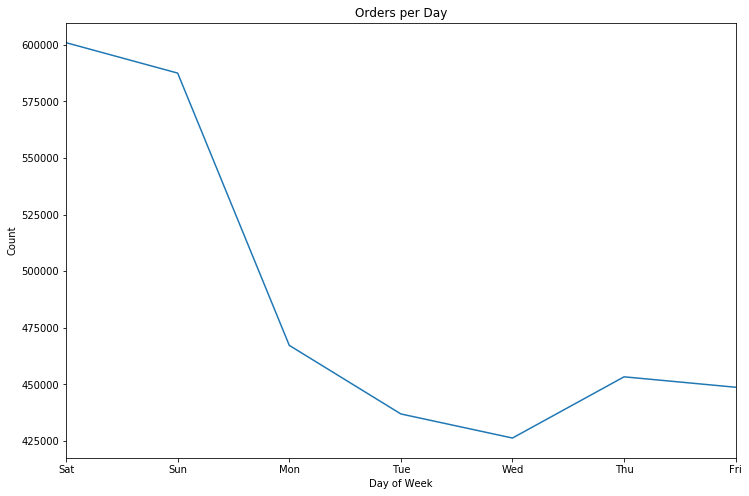

In [15]:
DayofWeek = orders.groupby(["order_dow"]).count()['order_id']
plt.figure(figsize=(12,8))
sns.tsplot(DayofWeek.values, DayofWeek.index)
plt.xticks(np.arange(7), ('Sat','Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri'))
plt.ylabel('Count')
plt.xlabel('Day of Week')
plt.title("Orders per Day")

Inference:
It will help the management to put in more people to work during these days. Thus allowing smooth operations.
Also this will allow the management to plan ahead and order stocks before these days, thus maintaing the flow of sales.

Plot5:
    Like the previous graph, this graph gives an idea on which hours of the day the sales is higher.


Text(0.5,1,'Orders by Hour of Day')

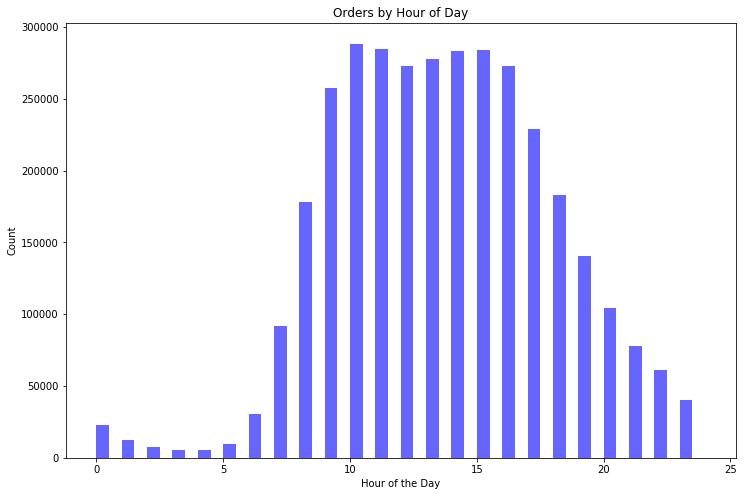

In [16]:
plt.figure(figsize=(12,8))
plt.hist(orders.order_hour_of_day, bins=np.arange(25), width=0.5, facecolor='blue', alpha=0.6)
plt.ylabel('Count')
plt.xlabel('Hour of the Day')
plt.title("Orders by Hour of Day")

Infernece:
It will help the management to put in more people to work and stock items during these timings. 
Thus resulting in smooth operations.

Plot6:This is the heat map of the day of the week and the hours of the day. 
Refered from: https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart

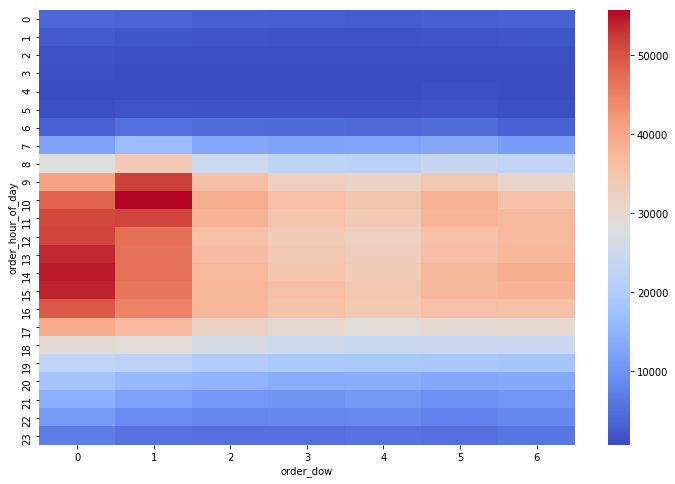

In [17]:
Hours_Day=orders.groupby(["order_hour_of_day","order_dow"])["order_number"].aggregate("count").reset_index()
Hours_Day_HeatMapdf = Hours_Day.pivot_table(index='order_hour_of_day',columns='order_dow', values='order_number', aggfunc='mean')
plt.figure(figsize=(12,8))
sns.heatmap(Hours_Day_HeatMapdf,cmap="coolwarm")

Infernece:
    Considering 0 as Saturday and 1 as Sunday, 
    We can say that the maximum rush is on Saturdays between 9 am to 5 pm and on Sundays between 8 am to 5 pm.

Plot7:The pie chart here gives us an idea of how people reorder stuff.

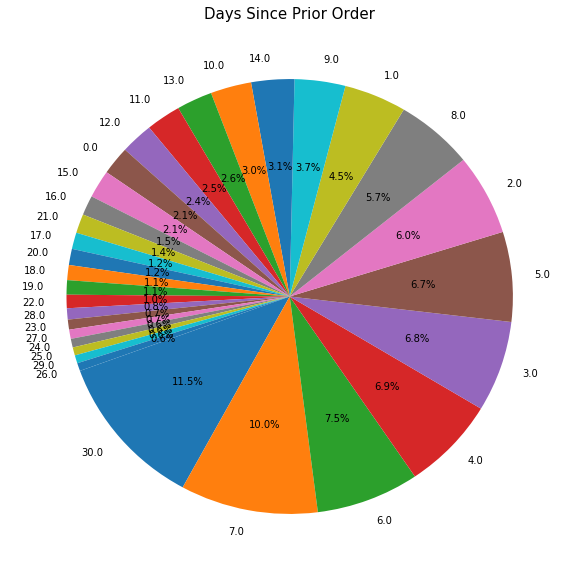

In [18]:
plt.figure(figsize=(10,10))
Days_Since_Prior_Order = orders['days_since_prior_order'].value_counts()
labels = (np.array(Days_Since_Prior_Order.index))
sizes = (np.array((Days_Since_Prior_Order / Days_Since_Prior_Order.sum())*100))
plt.pie(sizes, labels=labels,autopct='%1.1f%%', startangle=200)
plt.title("Days Since Prior Order", fontsize=15)
plt.show()

Infernece:
Here we see that maximum people like to reorder stuff weekly, this is what we as students do.
Another interesting fact is almost similar amount of people like to reorder their stuff monthly. 
So we have two kinds of people here, we can put in offers during these periods to attract more customers.

Plot8: Let us see what is the ratio of items being reordered by various users.
Refered from: https://www.kaggle.com/hiramfoster/exploratory-analysis-r-to-python-translation

    count  proportion (%)
1  828824           59.86
0  555793           40.14


([<matplotlib.axis.XTick at 0x15a8112de48>,
 <a list of 2 Text xticklabel objects>)

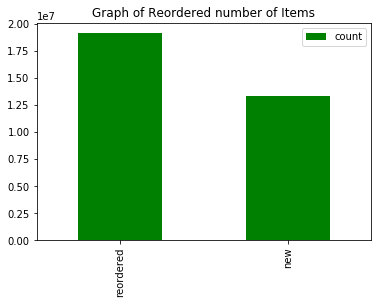

In [19]:
ReorderedCount = order_product_train['reordered'].value_counts().to_frame('count')
ReorderedCount['proportion (%)'] = (ReorderedCount['count']/ReorderedCount['count'].sum()*100).round(2)
print(ReorderedCount)
order_products_prior_df['reordered'].value_counts().to_frame('count').copy().plot(kind='bar',title='Graph of Reordered number of Items',color='green')
plt.xticks(np.arange(2),('reordered', 'new'))

Plot9: Here we are plotting graph of ratio of items reordered per department.
Refered from: https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

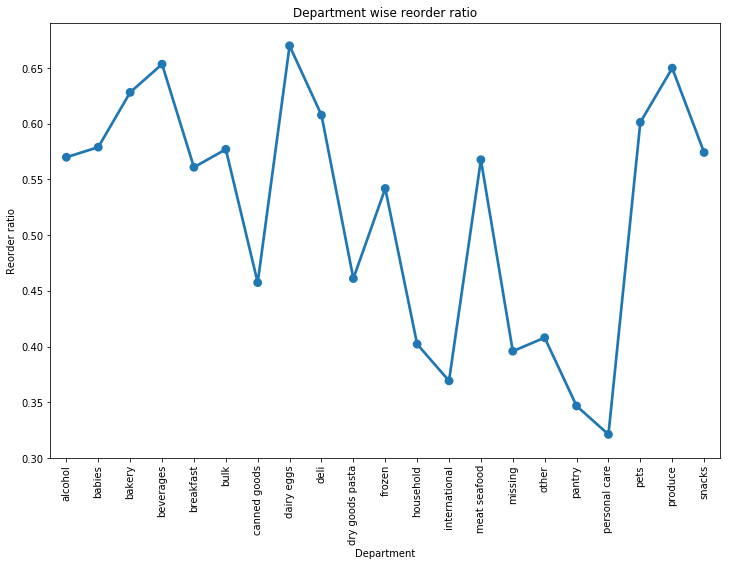

In [20]:
ReorderbyDept = order_products_prior_df.groupby(['department'])['reordered'].aggregate("mean").reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(ReorderbyDept['department'].values, ReorderbyDept['reordered'].values, alpha=0.8)
plt.ylabel('Reorder ratio')
plt.xlabel('Department')
plt.title("Department wise reorder ratio")
plt.xticks(rotation='vertical')

Infernece:
Dairy eggs, Produce, beverages, pets are the departments where the reordering ratio is high.
In one of the graphs above we had seen produce and dairy eggs sell max products, 
but when it comes to reordering ratio pets dept also comes into picture.

Inference:
The reordering data lets us know which aisle 
and departments need to be stocked up with large quantities as that they dont run out of supplies.

Plot10: It gives the count of each product in a department.

In [21]:
items  = pd.merge(left =pd.merge(left=product, right=department, how='left'), right=aisle, how='left')

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


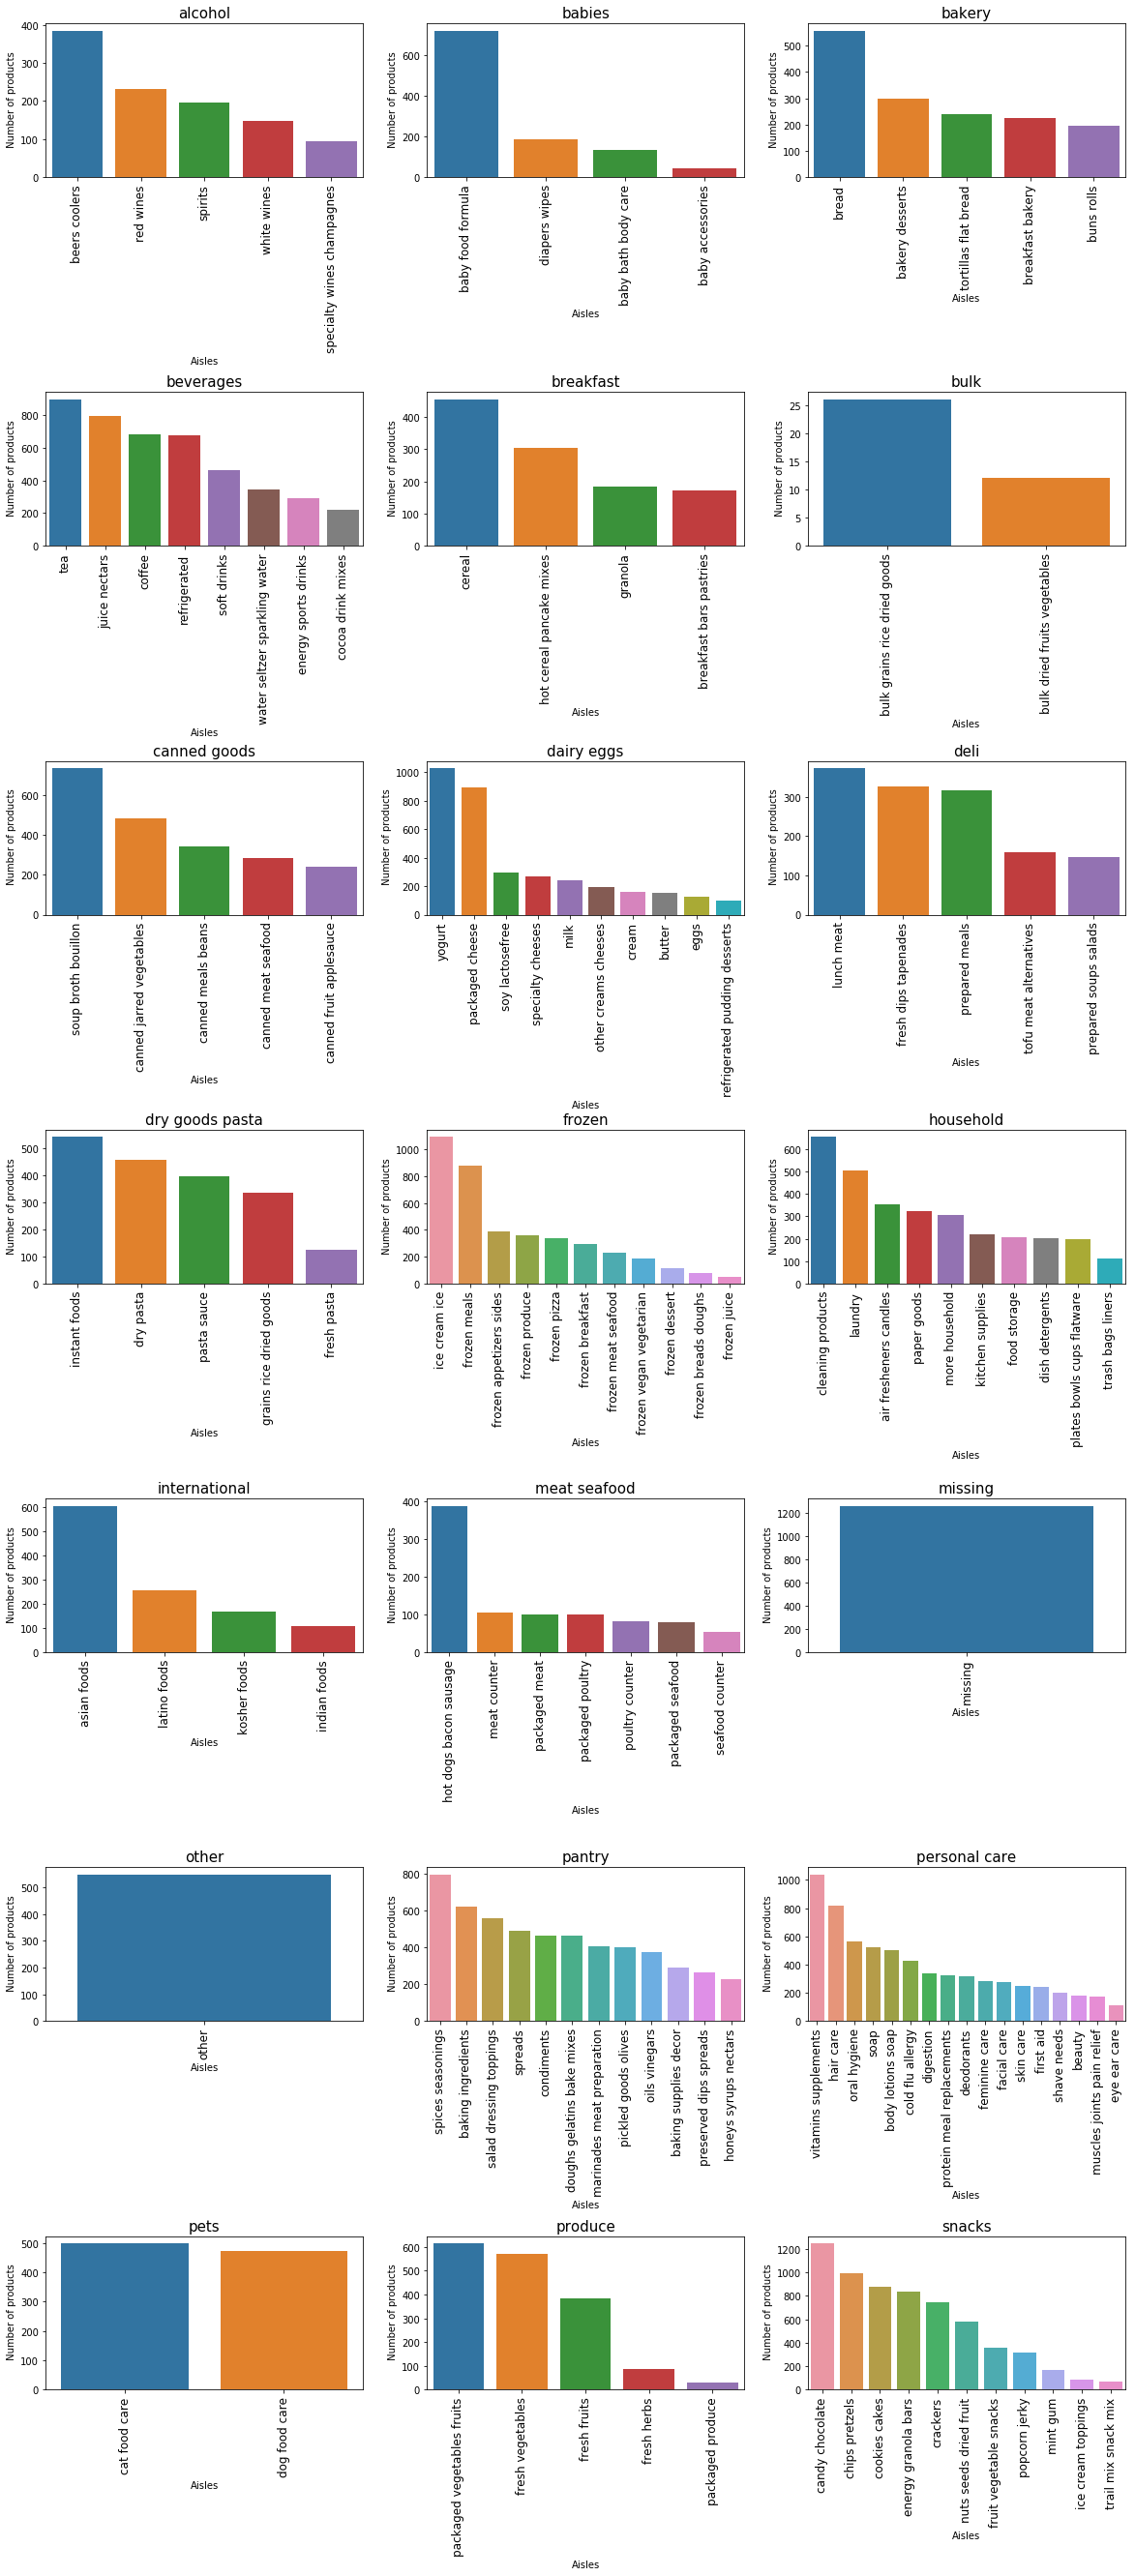

In [22]:
grouped = items.groupby(["department", "aisle"])["product_id"].aggregate({'Total_products': 'count'}).reset_index()
#grouped.nunique("product_id")
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

Inference:
    We can see the number of products in each departement under each aisle. This will help us collect more 
    stock for the products which are high in demand and to reduce the stock for the product which are not sold
    much.

# Association rules

We wanted to create Assocaition Rules using Python Generators that returns an iterable sequence of items and instead of using regular functions which return all the values at once (eg: returning all the elements of a list), we don't have to store all of the values in memory at once. We can load and process one value at a time, discard when finished and move on to process the next value. For Instacart Datasets which has huge volume of data(32 million records),Using Generator help us yield one value at a time and makes generators perfect for creating item pairs and counting their frequency of co-occurence.


In [23]:
orders = pd.read_csv('./order_products__prior.csv')

Size of the dataframe in MB of Orders Dataset

In [24]:
print('orders -- dimensions: {0};   size: {1}'.format(orders.shape,sys.getsizeof(orders) / (1000 * 1000)))

orders -- dimensions: (32434489, 4);   size: 1037.903752


In [25]:
# Convert from DataFrame to a Series, with order_id as index and item_id (product_id)as value
orders = orders.set_index('order_id')['product_id'].rename('item_id')
display(orders.head(10))
type(orders)

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
2    17794
2    40141
2     1819
2    43668
3    33754
Name: item_id, dtype: int64

pandas.core.series.Series

This gives the dimensions, size and count of unique orderid(index) and total unique item_id(product_id)

In [27]:
print('dimensions: {0};   size: {1};   unique_orders: {2};   unique_items: {3}'
      .format(orders.shape, sys.getsizeof(orders), len(orders.index.unique()), len(orders.value_counts())))

dimensions: (32434489,);   size: 518951848;   unique_orders: 3214874;   unique_items: 49677


# Association Rules Helper Functions:

Function: freq(obj) Returns the count of the item and item_pairs, If the input to function is series then return the count, else change the Dataframe to the Series and return the count by using Counter function in Python.

In [28]:
def freq(obj):
    if type(obj) == pd.core.series.Series:
        return obj.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(obj)).rename("freq")

Function: order_count(obj) Returns unique number of orders based on the order_id(index) using set function.

In [29]:
def order_count(obj):
    return len(set(obj.index))

Generator Function:get_item_pairs(obj)
This functions creates a pair of items after creating a matrix of the order_id and item_id,
and cretaing a list of items of same item_id, therby creating a combination of 2 items from the list 
and yeilds one iterbale at a time rather than  return all the values at once.


In [30]:
def get_item_pairs(obj):
    order_item = obj.reset_index().as_matrix()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair

Function: merge_item_stats(item_pairs, item_stats)
This function returns the frequency and the support associated with the item_pair.
The percentage of an item_pair that occurs in the set of orders is the support associated with the item_pair.
support{A,B}=freq(A,B)/total set of item_pair 

support{Milk,Egg}=freq(Milk,Egg)/total set of item_pair = 7/10 =70%

In [31]:
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))

Function: merge_item_name(rules, item_name)

This function merges the frequency, support, confidence and the lift of the item_pair to create a final dataframe of the results.

Confidence: Confidence indicates how often a rule has been found to be true. Confidence{A->B} = support{A,B} / support{A} Read as Confidence that B is purchased given that A was purchased. Confidence value ranges from 0 to 1. Where 0 indicates that B is never purchased when A was purchased. 1 indicates that B is purchased always when A is purchased.

Lift: Lift is a measure of the performance/importance of an association rule (i.e to say if the rule discovered was simply by chance or the two items actually holds some association).

lift{A,B} = lift{B,A} = support{A,B} / (support{A} * support{B})

In [32]:
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]   

# Association Rule function

Function association_rules(order_item, min_support):
In this function we pass the orders data along with a minimum support. This is the threshold value of the support for deciding the qualifying set of order pair.
Reference: https://www.kaggle.com/datatheque/association-rules-mining-market-basket-analysis/notebook

In [33]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item (product) frequency and support using the freq function
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support
    # Create a new series "qualifying_items" that will only contain the items having support greater than the minimum support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Since we are finding the association rules we would need atleast 2 items in every order, so now we filter out the 
    # order_items less than 2
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support as the orders with less than 2 items have been filtered out
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator: This will create the item pairs using the combination function in get_item_pairs()
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)


In [35]:
rules = association_rules(orders, 0.01)

Starting order_item:               32434489
Items with support >= 0.01:           10906
Remaining order_item:              29843570
Remaining orders with 2+ items:     3013325
Remaining order_item:              29662716
Item pairs:                        30622410
Item pairs with support >= 0.01:      48751



In [36]:
# Replace item ID with item name and display association rules
item_name   = pd.read_csv('./products.csv')
item_name   = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_out = merge_item_name(rules, item_name).sort_values('lift', ascending=False)
display(rules_out.head(10))

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Organic Strawberry Chia Lowfat 2% Cottage Cheese,Organic Cottage Cheese Blueberry Acai Chia,306,0.010155,1163,0.038595,839,0.027843,0.263113,0.364720,9.449868
1,Grain Free Chicken Formula Cat Food,Grain Free Turkey Formula Cat Food,318,0.010553,1809,0.060033,879,0.029170,0.175788,0.361775,6.026229
3,Organic Fruit Yogurt Smoothie Mixed Berry,Apple Blueberry Fruit Yogurt Smoothie,349,0.011582,1518,0.050376,1249,0.041449,0.229908,0.279424,5.546732
9,Nonfat Strawberry With Fruit On The Bottom Gre...,"0% Greek, Blueberry on the Bottom Yogurt",409,0.013573,1666,0.055288,1391,0.046162,0.245498,0.294033,5.318230
10,Organic Grapefruit Ginger Sparkling Yerba Mate,Cranberry Pomegranate Sparkling Yerba Mate,351,0.011648,1731,0.057445,1149,0.038131,0.202773,0.305483,5.317849
11,Baby Food Pouch - Roasted Carrot Spinach & Beans,"Baby Food Pouch - Butternut Squash, Carrot & C...",332,0.011018,1503,0.049878,1290,0.042810,0.220892,0.257364,5.159830
12,Unsweetened Whole Milk Mixed Berry Greek Yogurt,Unsweetened Whole Milk Blueberry Greek Yogurt,438,0.014535,1622,0.053828,1621,0.053794,0.270037,0.270204,5.019798
23,Uncured Cracked Pepper Beef,Chipotle Beef & Pork Realstick,410,0.013606,1839,0.061029,1370,0.045465,0.222947,0.299270,4.903741
24,Organic Mango Yogurt,Organic Whole Milk Washington Black Cherry Yogurt,334,0.011084,1675,0.055586,1390,0.046128,0.199403,0.240288,4.322777
2,Grain Free Chicken Formula Cat Food,Grain Free Turkey & Salmon Formula Cat Food,391,0.012976,1809,0.060033,1553,0.051538,0.216142,0.251771,4.193848


lift = 1 implies no relationship between A and B. 
   (ie: A and B occur together only by chance)

lift > 1 implies that there is a positive relationship between A and B.
   (ie:  A and B occur together more often than random)

lift < 1 implies that there is a negative relationship between A and B.
   (ie:  A and B occur together less often than random)
   
So we will only consider lift > 1

In [37]:
rules_final = rules_out[rules_out['lift'] > 1]

In [38]:
rules_merge = rules_final["itemA"].map(str) + ", " + rules_final["itemB"]

rules_freq=rules_final['freqAB']

In [39]:
rules_display=pd.concat([rules_merge,rules_freq],axis=1)
rules_display.rename(columns={ rules_display.columns[0]: "item_sets" },inplace=True)

In [40]:
rules_display = rules_display.sort_values('freqAB', ascending=False).reset_index()
print(rules_display.head())

   index                                          item_sets  freqAB
0   4045  Almond Milk Strawberry Yogurt, Almond Milk Blu...    1640
1   5844  Yotoddler Organic Pear Spinach Mango Yogurt, O...    1533
2   4052  Almond Milk Strawberry Yogurt, Almond Milk Pea...    1376
3   8222  Organic Whole Milk Strawberry Beet Berry Yogur...    1290
4   4046  Almond Milk Peach Yogurt, Almond Milk Blueberr...    1289


In [41]:
rules_display = rules_display[0:10]

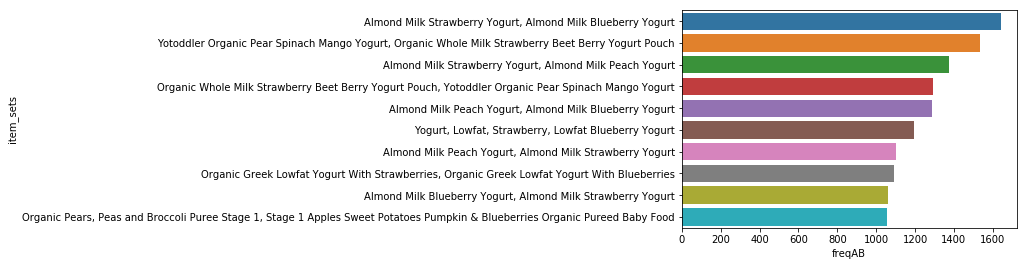

In [42]:
sns.barplot(x=rules_display['freqAB'], y=rules_display['item_sets'])

From the above graph we can infer that the item pair ("Almond Milk Strawberry Yogurt, Almond Milk Blueberry Yogurt") occur more often in the same order. So we may recommend the "Almond Milk Blueberry Yogurt" to the user who has added "Almond Milk Strawberry Yogurt" to his cart.


# Finding the Users having likeness for the same Products using TFIDF.

In [38]:
products = pd.read_csv("./products.csv").set_index('product_id')
orders = pd.read_csv("./orders.csv")
prior_orders = pd.read_csv("./order_products__prior.csv")
aisle=pd.read_csv("./aisles.csv")

Merge the file containing prior orders and orders, therby merge it with product dataset on basis of 
product_id.
Taken references from:
    https://www.kaggle.com/tedchang0102/using-tfidf-as-user-s-affinity

In [39]:
prior_orders = prior_orders[prior_orders.reordered==1]
prior_ord = pd.merge(prior_orders,orders,on='order_id',how='left')
products = products.reset_index()
prior_ord.head()
prior_ord = pd.merge(prior_ord,products,on='product_id',how='left')
prior_ord[['user_id','order_id','product_id','product_name','reordered']].head()

,user_id,order_id,product_id,product_name,reordered
0,202279,2,33120,Organic Egg Whites,1
1,202279,2,28985,Michigan Organic Kale,1
2,202279,2,45918,Coconut Butter,1
3,202279,2,17794,Carrots,1
4,202279,2,40141,Original Unflavored Gelatine Mix,1


#We need user_id and list of products which are associated with the user.

In [40]:
prior_ord["product_name"] = prior_ord["product_name"].astype(str)
prior_order = prior_ord.groupby("user_id").apply(lambda order: order['product_name'].tolist())
prior_order = prior_order.reset_index()
prior_order.columns = ['user_id','product_set']
prior_order.product_set = prior_order.product_set.astype(str)
prior_order.head()

,user_id,product_set
0,1,"['Soda', 'Original Beef Jerky', 'Pistachios', ..."
1,2,"['Chipotle Beef & Pork Realstick', 'Chipotle B..."
2,3,"['Organic Baby Spinach', 'Unsweetened Chocolat..."
3,4,['Enchilada Black Bean Vegetable']
4,5,"['Plain Whole Milk Yogurt', 'Whole Vitamin D M..."


Using TFIDF which stands for term frequency-inverse document frequency,which is
used to evaluate how important a word is to a document in a collection or corpus.

TF:Measures how frequently a term occurs in a document.
TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF: measures how important a term is.
IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [41]:
#we have taken refernece from the code 
tfidf = TfidfVectorizer(min_df=5, max_features=1000
                        , strip_accents='unicode',lowercase =True,
analyzer='word', token_pattern=r'\w+', use_idf=True, 
smooth_idf=True, sublinear_tf=True, stop_words = 'english')
tfidf.fit(prior_order['product_set'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w+', tokenizer=None, use_idf=True,
        vocabulary=None)

In [42]:
text = tfidf.transform(prior_order['product_set'])
svd = TruncatedSVD(n_components=3)
text = svd.fit_transform(text)
text = pd.DataFrame(text)
text.columns = ['pf_0','pf_1','pf_3']
text['user_id'] = prior_order.user_id
text.head()

,pf_0,pf_1,pf_3,user_id
0,0.163496,-0.104404,0.048146,1
1,0.406453,-0.148391,-0.072276,2
2,0.398428,0.082559,0.028958,3
3,0.060366,-0.013503,-0.017542,4
4,0.263798,0.154847,-0.020523,5


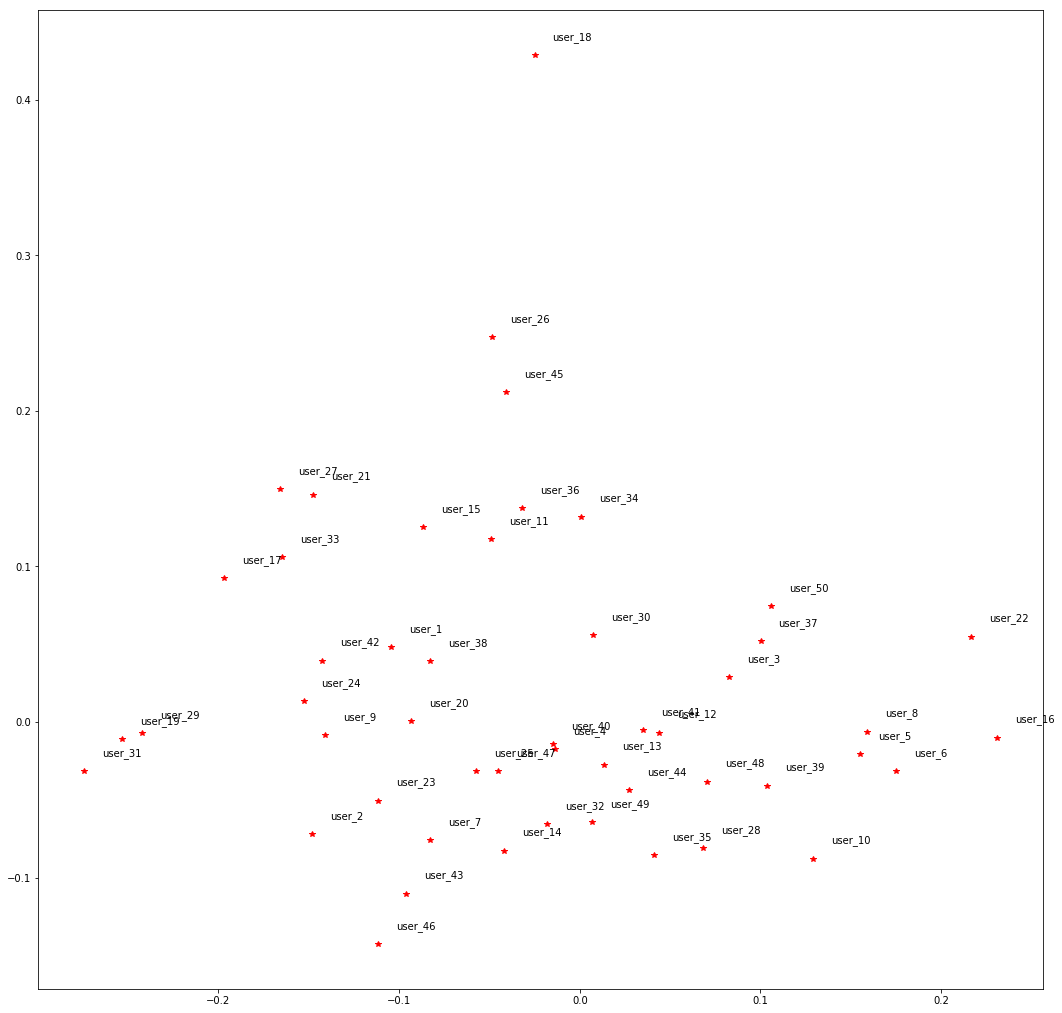

In [43]:
plt.figure(figsize=(18,18))
plt.plot(text['pf_1'].head(50),text['pf_3'].head(50),'r*',label=text['user_id'].head(50))
for row in text.head(50).itertuples():
    plt.annotate('user_'+str(row.user_id), xy=(row.pf_1,row.pf_3), 
            xytext=(row.pf_1+0.01,row.pf_3+0.01)
            
            )

In [61]:
print(prior_ord[prior_ord['user_id']==19]['product_name'].unique())

['100% Juice Apple Juice' 'Shredded Sharp Cheddar Cheese'
 'Naturally Hickory Smoked Thick Cut Bacon'
 'Boomchickapop Sweet & Salty Kettle Corn' 'Soda'
 'Peanut Butter Dark Chocolate Protein Chewy Bars'
 'PM Extra Strength Caplets' 'Original Miracle Whip Dressing'
 'Kiwi Strawberry with Electrolytes & Vitamins Water Beverage'
 'Grilled & Ready Chicken Breast Strips'
 'Bold & Crispy Zesties! Crispy Seasoned French Fried Potatoes'
 'Lemon with Electrolytes & Vitamins Water Beverage' 'Lemon Dish Liquid'
 'Skim Milk' 'Slow Churned Ice Cream, Peanut Butter Cup, Light'
 'Sweet Mini Sub Rolls' 'Prepared Cheese Product Slices'
 'Vermont White Cheddar Macaroni & Cheese Dinner'
 'The Original Five Cheese Texas Toast'
 'Cafe Steamer Sweet & Sour Chicken' 'Sesame Chicken'
 'Honey Barbecue Sauce' 'Grands! Big & Flaky Crescent Rolls'
 'Crispy Chicken Strips 100% All Natural Fully Cooked'
 'Coke Zero Diet Soda' 'Sour Cream & Onion Flavored Potato Crisps'
 'Original Velveeta Cheese' 'Moisturizing Sham

In [62]:
print(prior_ord[prior_ord['user_id']==29]['product_name'].unique())

['Bars Peanut Butter' 'Honey Buns' 'Oatmeal Crème Pies'
 'Cran-Apple Juice Drink' 'Caramel Cone Ice Cream' 'Creamed Chipped Beef'
 'Rotisserie Deli Shave Chicken Breast'
 'Creamy Swiss Garlic & Herb Spreadable Cheese Wedges'
 'Original Fresh Stack Crackers' 'Glazed Lemon Pie'
 'Fancy Shredded Sharp Cheddar Cheese'
 'Extra Soft Double Roll Bathroom Tissue'
 "Chef's Favorites Lightly Sauced Rotini & Vegetables with Oven Roasted Garlic Butter Sauce"
 'Original 0 Calorie Sweetener Packets 115 Count'
 'Town House Italian Herb Flatbread Crisps'
 'Original Baked Snack Crackers' 'Chicken Fried Rice' 'Mini Oreo Go Pak'
 'Pure Life Purified Water' 'Allergy Relief'
 'Vanilla Caramel Coffee Creamer' 'Regular Chips' 'Bacon Breakfast Bowl'
 'Creamy Peanut Butter' 'Minis Candy' 'Fettuccine Alfredo'
 'Original Roast Coffee' '90 Calorie Lemon Bars' 'Pimento Cheese Spread'
 'Scoops' 'Old Fashioned Buttermilk Ranch Salad Dressing'
 'Smoothies Extra Strength 750 Antacid Calcium Supplement Chewable Tablets

Analysis: As we can see the user19 and user 29 has some of the similar likeness of buying a product,
        hence we can suggest some product of user 19 to user 29 depending upon the choice.
        
        Example: User29 can be suggested 'Peanut Butter Dark Chocolate Protein Chewy Bars' and 
                 
                 Users19  can be suggested 'Bars Peanut Butter'
                 
                 Similarly Chicken Products can be suggested to each other.It can be also seen that 
                
                 both of them prefer sauces and hence can be suggested to each other.

# Identification of Customer Segments using PCA and KMeans

Clustering using PCA and KMeans
Prepare the dataset to create an cross tab  with user_id and the aisle from which the user has purchased
the product.

In [44]:
#Prepare the dataset
order_basket = pd.merge(prior_orders, products, on = ['product_id','product_id'])
order_basket = pd.merge(order_basket,orders,on=['order_id','order_id'])
order_basket= pd.merge(order_basket,aisle,on=['aisle_id','aisle_id'])
order_basket.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
2,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs
3,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.0,eggs
4,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0,eggs
5,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0,eggs
6,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.0,eggs
7,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,eggs
8,689,35921,3,1,Organic Large Grade A Brown Eggs,86,16,108932,prior,16,1,13,3.0,eggs
9,726,33120,3,1,Organic Egg Whites,86,16,57362,prior,25,2,17,7.0,eggs


In [45]:
print(order_basket['aisle'].value_counts()[0:10])
print(len(order_basket['aisle'].unique()))

fresh fruits                     2615469
fresh vegetables                 2032172
packaged vegetables fruits       1127177
yogurt                            997018
milk                              696264
water seltzer sparkling water     613977
packaged cheese                   573383
soy lactosefree                   442023
chips pretzels                    425387
bread                             391937
Name: aisle, dtype: int64
134


In [46]:
#Crosstab with the user_id and the aisle from which the user buys the product.
cust_prod=pd.crosstab(order_basket['user_id'],order_basket['aisle'])
cust_prod.head(10)


aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,28
3,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7


Implementing PCA and transforming the dataframe for dimensionality reduction

In [47]:

from sklearn.decomposition import PCA
pca=PCA(n_components=6)
pca.fit(cust_prod)
pca_samples=pca.transform(cust_prod)

In [48]:
ps_frame=pd.DataFrame(pca_samples)
ps_frame.head()

,0,1,2,3,4,5
0,-17.515222,0.542633,-0.417410,-1.008532,1.945493,-0.977200
1,1.992884,21.775972,7.287902,10.581793,-5.785676,-0.597976
2,-4.647817,1.308640,-7.991429,1.058714,0.645986,-3.120443
3,-19.755350,-1.225824,-0.200696,1.950737,-0.356387,0.400564
4,-14.812774,-0.582278,0.041951,2.767464,0.325638,-0.354219


Creating a plot to determine the clusters of users using the dimensions 4 and Dimension 1.
Taken refernce from :
https://www.kaggle.com/asindico/customer-segments-with-pca

(203164, 2)
          4          1
0  1.945493   0.542633
1 -5.785676  21.775972
2  0.645986   1.308640
3 -0.356387  -1.225824
4  0.325638  -0.582278


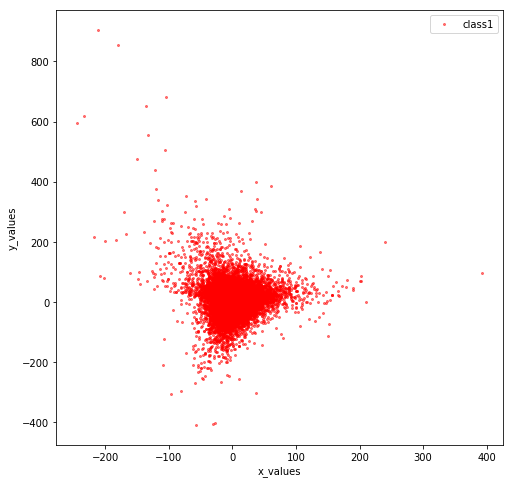

In [49]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(ps_frame[[4,1]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[1], 'o', markersize=2, color='red', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

Applying Kmeans to identify the cluster using the centres and thereby determining various cluster to which the users
belong.

In [50]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[-1.10590695e-01 -8.19895104e-01]
 [ 6.39059702e+00  3.16244282e+01]
 [-5.12183643e+00 -4.74253836e+01]
 [-3.33415984e+01  1.51948969e+02]]


In [51]:
print(c_preds[0:100])

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0]


To draw the clusters of the users based on the above predictions.

['orange', 'blue', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


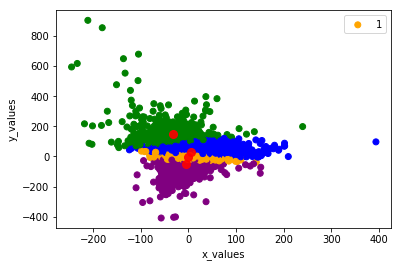

In [52]:
colors=['orange','blue','purple','green']
colored=[colors[k] for k in c_preds]
print(colored[0:10])
plt.scatter(tocluster[4],tocluster[1],color=colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o',markersize=8, color='red', alpha=0.9)
    
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

Analysis: The users are identified belonging to various clusters and then a scatter plot showing the 
          users cluster.
          
          The first user belong to cluster 0 will lie near the color orange in the plot.
          Similarly we can see that there are huge number of people belonging to cluster 3 and so on.

Creating the dataframe containing the cluster column appended to it.

In [53]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds
clust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,28,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,7,0


Creating the mean of the products bought by each aisle and plotting the graph on each cluster.

(203164, 135)
aisle
air fresheners candles           0.026968
asian foods                      0.198513
baby accessories                 0.013420
baby bath body care              0.008181
baby food formula                0.540598
bakery desserts                  0.063670
baking ingredients               0.339105
baking supplies decor            0.013915
beauty                           0.005012
beers coolers                    0.121886
body lotions soap                0.052670
bread                            1.342037
breakfast bakery                 0.527432
breakfast bars pastries          0.134271
bulk dried fruits vegetables     0.033005
bulk grains rice dried goods     0.028143
buns rolls                       0.220162
butter                           0.518022
candy chocolate                  0.539499
canned fruit applesauce          0.154406
canned jarred vegetables         0.434740
canned meals beans               0.474196
canned meat seafood              0.123746
cat food care 

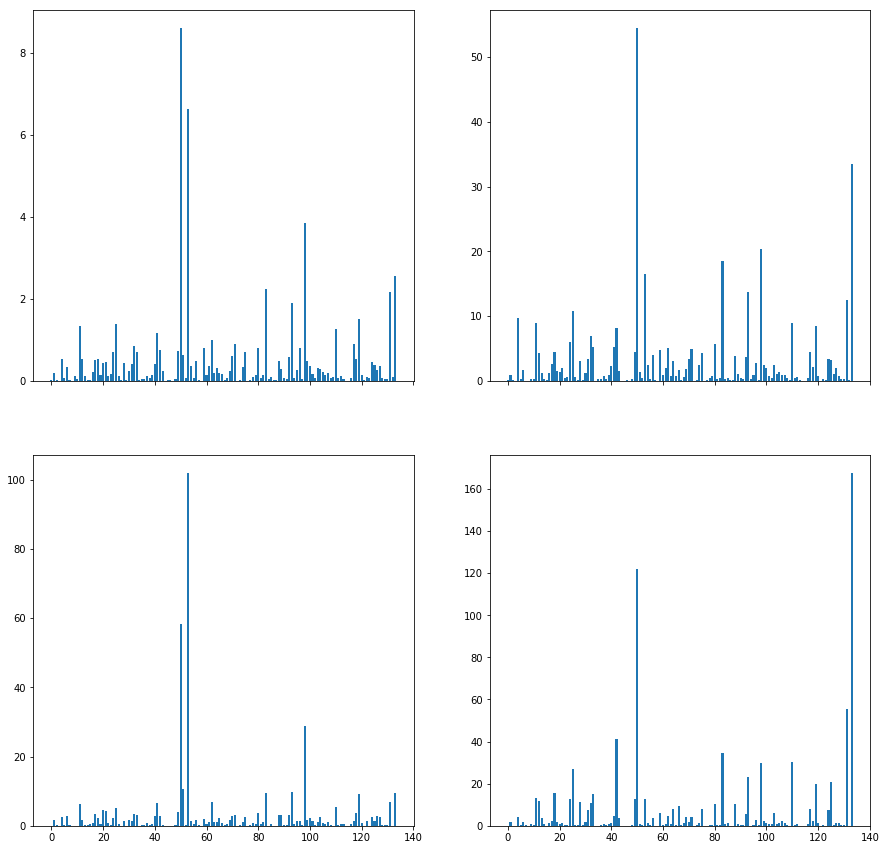

In [56]:
print (clust_prod.shape)
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c0.sort_values(ascending=False)[0:10]
#Creating a bar plot with the mean of each product in various cluster.
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)
print(c0)
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c1.sort_values(ascending=False)[0:10]
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
c2.sort_values(ascending=False)[0:10]
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)
c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
c3.sort_values(ascending=False)[0:10]
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)
plt.show()

Identifying the various cluster and the mean of the each products purchased by them.

In [57]:

c0.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     8.596341
fresh vegetables                 6.630687
packaged vegetables fruits       3.838173
yogurt                           2.552072
milk                             2.237871
water seltzer sparkling water    2.168337
packaged cheese                  1.890472
soy lactosefree                  1.518496
chips pretzels                   1.393533
bread                            1.342037
dtype: float64

In [58]:
c1.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     54.442067
yogurt                           33.455394
packaged vegetables fruits       20.360109
milk                             18.439982
fresh vegetables                 16.502357
packaged cheese                  13.679964
water seltzer sparkling water    12.482230
chips pretzels                   10.849048
baby food formula                 9.780508
refrigerated                      8.968359
dtype: float64

In [59]:
c2.sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 101.990509
fresh fruits                      58.176490
packaged vegetables fruits        28.857975
fresh herbs                       10.511156
packaged cheese                    9.689311
milk                               9.601565
yogurt                             9.581752
soy lactosefree                    9.221612
water seltzer sparkling water      6.990676
frozen produce                     6.884282
dtype: float64

In [60]:
c3.sort_values(ascending=False)[0:10]

aisle
yogurt                           167.681661
fresh fruits                     121.996540
water seltzer sparkling water     55.323529
energy granola bars               41.013841
milk                              34.544983
refrigerated                      30.202422
packaged vegetables fruits        29.603806
chips pretzels                    26.790657
packaged cheese                   23.394464
tea                               20.717993
dtype: float64

Conclusion:
    It has been concluded that maximum products are sold from the department produce.
    
    Usually,Customers has more affinity to buy fresh fruits and fresh vegetables.
    There are group of cutsomers who buys baby products and hence can be given updates about 
    new baby products which comes to the store.
    
    Clsuter3 belongs to the customer who purchase a lot of the store and can be given a loyalty
    card to value them. Cluster 0 belongs to users with less frequent orders and can be given discount 
    to attract them depending on the products they prefer to buy previously.